### Simulation (SPN)
- 3 종류의 파라미터 세트로 실험 진행 
    - Untangling Basal Ganglia Network Dynamics and Function
        - 시간에 따라 I를 바꿔가며 입력 
    - Action selection in the rhythmic brain: The role of the basal ganglia and tremor
    - The onset of motor learning impairments in Parkinson’s disease: a computational investigation

In [1]:
### Library
from brian2 import *
import brian2 as br
from brian2tools import *
import matplotlib.pyplot as plt
import random
import numpy as np
from brian2.units import *
from neuron import h, gui
from brian2 import ms, mV, pA, pF, siemens, amp, second, NeuronGroup, defaultclock, run
import json
import numpy as np

pS = siemens * 1e-12

--No graphics will be displayed.


In [2]:
# Neuron parameters (Set 1)
# eNeuro

N = 100
C = 80 * br.pF 
K = 1

KAPA = 0.0289   # Humphries etal 2009a
ALPHA = 0.032   # Humphries etal 2009a

WARNING    'a' is an internal variable of group 'neurongroup_2', but also exists in the run namespace with the value 200. * hertz. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'b' is an internal variable of group 'neurongroup_2', but also exists in the run namespace with the value 25. * hertz. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'u' is an internal variable of group 'neurongroup_2', but also exists in the run namespace with the value 0. * volt. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'v' is an internal variable of group 'neurongroup_2', but also exists in the run namespace with the value array([-80.        , -73.33698402, -69.78786971, ...,  19.57871608,
       -60.        , -59.41900825]) * mvolt. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'v

Earliest time when v reaches vr (in ms): 11.0


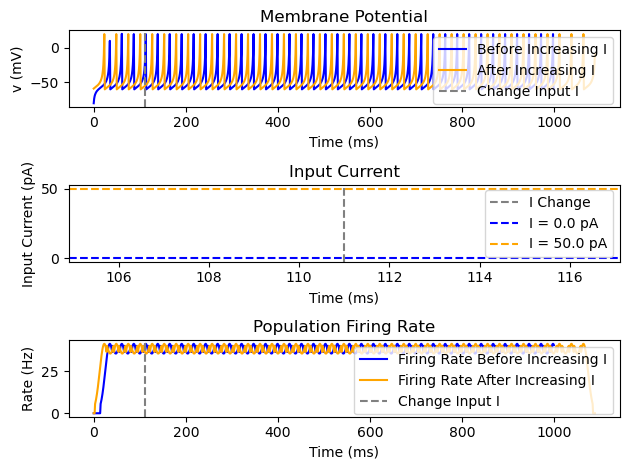

In [8]:
### Set 1
# Compare experimental result with I 

eqs = '''
dv/dt = (K*1*pF/ms/mV*(v-VR)*(v-vt)-u*pF+I)/C: volt
du/dt = a*(b*(v-VR)-u) : volt/second
VR = vr*(1+KAPA*Dop1) : volt
K = k*(1-ALPHA*Dop2) : 1
a       : 1/second
b       : 1/second
c       : volt
d       : volt/second
k       : 1
vr      : volt
vt      : volt
vpeak   : volt
I : amp
Dop1      : 1
Dop2      : 1
'''

simulation_time = 5000 * ms
time_after_c_reach = 100 * ms  # Time after reaching c to increase I
initial_I = 10 * pA
new_I = 50 * pA  # New input current value

dSPN = NeuronGroup(N, model = eqs,
                    threshold='v > vpeak',
                    reset='v = c; u += d',
                    method='euler')

dSPN.v = -80 * mV
dSPN.u = 0 * mV / ms
dSPN.a = 0.2 / ms
dSPN.b = 0.025 / ms
dSPN.c = -60 * mV
dSPN.d = 0 * mV / ms
dSPN.k = 1
dSPN.vr = -64.4 * mV
dSPN.vt = -50 * mV
dSPN.vpeak = 25 * mV
dSPN.I = 100 * pA
dSPN.Dop1 = 0.5
dSPN.Dop2 = 0.5

dv_monitor = StateMonitor(dSPN, variables='v', record=True)
spike_monitor = SpikeMonitor(dSPN)
rate_monitor = PopulationRateMonitor(dSPN)  # Bin size of 10ms

# Include rate_monitor in the Network
net = Network(dSPN, dv_monitor, spike_monitor, rate_monitor)
net.run(simulation_time)

# Find the time when v reaches vr
# vr_val = dSPN.vr[0].item() # vr이 아닌 c로 바꿔야할듯  
c_val = dSPN.c[0].item()
times_c_reached = []

for i in range(N):
    v = dv_monitor.v[i]
    times = dv_monitor.t
    crossing_indices = np.where(np.diff((v >= c_val).astype(int)) == 1)[0]
    
    if len(crossing_indices) > 0:
        # Convert indices to times
        times_c_reached.extend(times[crossing_indices + 1])
    
# Convert times to milliseconds for plotting
times_c_reached_ms = np.array(times_c_reached) / ms
initial_I = 0 * pA
increased_I = 100 * pA
times_c_reached_ms = np.array(times_c_reached) * 1000  # Convert seconds to milliseconds

# Find the earliest time when v reaches c
if len(times_c_reached_ms) > 0:
    earliest_time_c = min(times_c_reached_ms)
else:
    earliest_time_c = None

# Print the time when v first reaches vr
print("Earliest time when v reaches vr (in ms):", earliest_time_c)

if earliest_time_c is not None:
    # Define new neuron group with increased input
    dSPN_new = NeuronGroup(N, model=eqs,
                           threshold='v > vpeak',
                           reset='v = c; u += d',
                           method='euler')

    # Copy parameters
    dSPN_new.v = dSPN.v
    dSPN_new.u = dSPN.u
    dSPN_new.a = dSPN.a
    dSPN_new.b = dSPN.b
    dSPN_new.c = dSPN.c
    dSPN_new.d = dSPN.d
    dSPN_new.k = dSPN.k
    dSPN_new.vr = dSPN.vr
    dSPN_new.vt = dSPN.vt
    dSPN_new.vpeak = dSPN.vpeak
    dSPN_new.I = increased_I  # Increased input current
    dSPN_new.Dop1 = dSPN.Dop1
    dSPN_new.Dop2 = dSPN.Dop2
    C = 80 * br.pF 

    # Create new monitors
    dv_monitor_new = StateMonitor(dSPN_new, variables='v', record=True)
    spike_monitor_new = SpikeMonitor(dSPN_new)
    rate_monitor_new = PopulationRateMonitor(dSPN_new)  # Bin size of 10ms

    # Create and run new network
    net_new = Network(dSPN_new, dv_monitor_new, spike_monitor_new, rate_monitor_new)
    
    # Run for the remaining time plus the time after v reaches vr
    net_new.run(simulation_time - earliest_time_c * ms + time_after_c_reach)

    # Plot membrane potential
    plt.subplot(3, 1, 1)
    plt.plot(dv_monitor.t / ms, dv_monitor.v[0] / mV, label='Before Increasing I', color='blue')
    plt.plot(dv_monitor_new.t / ms, dv_monitor_new.v[0] / mV, label='After Increasing I', color='orange')
    plt.axvline(x=earliest_time_c + (time_after_c_reach / ms), color='gray', linestyle='--', label='Change Input I')
    plt.xlabel('Time (ms)')
    plt.ylabel('v (mV)')
    plt.title('Membrane Potential')
    plt.legend()

    # Plot input current
    plt.subplot(3, 1, 2)
    plt.axvline(x=earliest_time_c + (time_after_c_reach / ms), color='gray', linestyle='--', label='I Change')
    plt.axhline(y=initial_I / pA, color='blue', linestyle='--', label=f'I = {initial_I / pA} pA')
    plt.axhline(y=new_I / pA, color='orange', linestyle='--', label=f'I = {new_I / pA} pA')
    plt.xlabel('Time (ms)')
    plt.ylabel('Input Current (pA)')
    plt.title('Input Current')
    plt.legend()

    # Plot firing rate
    plt.subplot(3, 1, 3)
    plt.plot(rate_monitor.t / ms, rate_monitor.smooth_rate(width=10*ms) / Hz, label='Firing Rate Before Increasing I', color='blue')
    plt.plot(rate_monitor_new.t / ms, rate_monitor_new.smooth_rate(width=10*ms) / Hz, label='Firing Rate After Increasing I', color='orange')
    plt.axvline(x=earliest_time_c + (time_after_c_reach / ms), color='gray', linestyle='--', label='Change Input I')
    plt.xlabel('Time (ms)')
    plt.ylabel('Rate (Hz)')
    plt.title('Population Firing Rate')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [123]:
### Input current 

eqs = '''
dv/dt = (K*1*pF/ms/mV*(v-VR)*(v-vt)-u*pF+I)/C: volt
du/dt = a*(b*(v-VR)-u) : volt/second
VR = vr*(1+KAPA*Dop1) : volt
K = k*(1-ALPHA*Dop2) : 1
a       : 1/second
b       : 1/second
c       : volt
d       : volt/second
k       : 1
vr      : volt
vt      : volt
vpeak   : volt
I : amp
Dop1      : 1
Dop2      : 1
'''

dSPN = NeuronGroup(N, model = eqs,
                    threshold='v > vpeak',
                    reset='v = c; u += d',
                    method='euler')


dSPN.v = -80 * mV
dSPN.u = 0 * mV / ms
dSPN.a = 0.2 / ms
dSPN.b = 0.025 / ms
dSPN.c = -60 * mV
dSPN.d = 0 * mV / ms
dSPN.k = 1
dSPN.vr = -64.4 * mV 
dSPN.vt = -50 * mV
dSPN.vpeak = 25 * mV
dSPN.I = 0 * pA
dSPN.Dop1 = 0.5
dSPN.Dop2 = 0.5

In [124]:
# Parameter Settings 
simulation_time = 3000 * ms  # 전체 시뮬레이션 시간
time_after_increase = 1000 * ms  # 전류 증가 후 시간
time_after_decrease = 1000 * ms  # 전류 감소 후 시간

dv_monitor = StateMonitor(dSPN, variables='v', record=True)
spike_monitor = SpikeMonitor(dSPN)
rate_monitor = PopulationRateMonitor(dSPN)  # 10ms의 bin 크기

net = Network(dSPN, dv_monitor, spike_monitor, rate_monitor)
net.run(simulation_time)

# Find the Stabilization time point
v_reset = -66 * mV 
membrane_potential = dv_monitor.v  
times = dv_monitor.t 

matching_indices = np.where(membrane_potential / mV >= v_reset / mV)[0]

if len(matching_indices) > 0:
    earliest_time_stabilized = times[matching_indices[0]] * 1000
else:
    earliest_time_stabilized = None

print("Earliest time when v stabilizes at v_reset (in ms):", earliest_time_stabilized)

Earliest time when v stabilizes at v_reset (in ms): 0. s


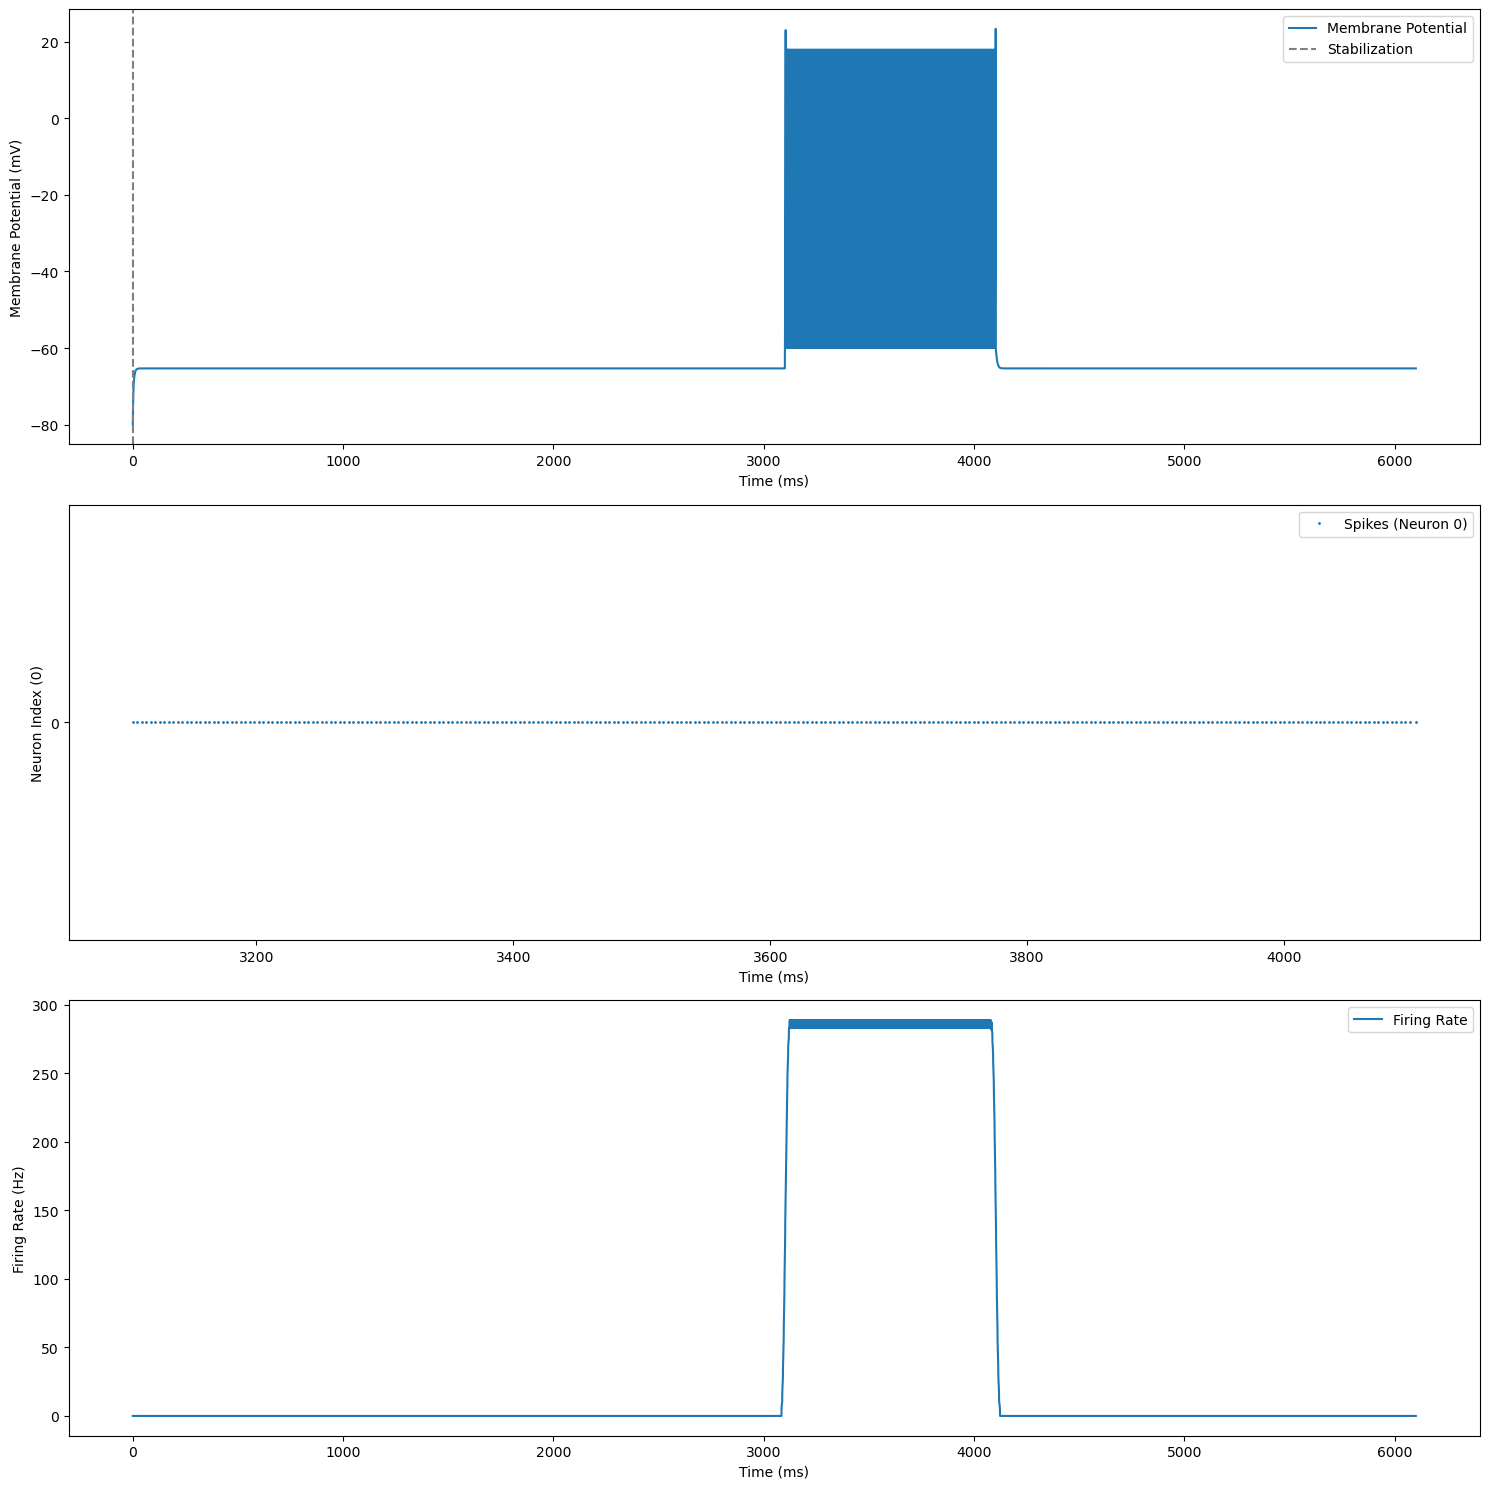

In [126]:
### Simulation 
dv_monitor_new = StateMonitor(dSPN, variables='v', record=True)
spike_monitor_new = SpikeMonitor(dSPN)
rate_monitor_new = PopulationRateMonitor(dSPN)  # 10ms의 bin 크기

net.add(dv_monitor_new, spike_monitor_new, rate_monitor_new)

# Input current 
if earliest_time_stabilized is not None:
    # Increase I 
    wait_time_after_stabilization = 100 * ms
    net.run(wait_time_after_stabilization)
    dSPN.I = 1 * nA
    net.run(time_after_increase)
    
    # decrease I
    dSPN.I = 0 * pA
    net.run(time_after_decrease)

    # resimulation 
    net.run(simulation_time - earliest_time_stabilized - time_after_increase - time_after_decrease)
else:
    print("v do not reach v_reset, stop simulation")

### visualization 
plt.figure(figsize=(15, 15))

plt.subplot(3, 1, 1)
plt.plot(dv_monitor.t / ms, dv_monitor.v[0] / mV, label='Membrane Potential')
plt.axvline(x=earliest_time_stabilized / ms, color='gray', linestyle='--', label='Stabilization')
plt.xlabel('Time (ms)')
plt.ylabel('Membrane Potential (mV)')
plt.legend()

plt.subplot(3, 1, 2)
spikes_of_neuron_0 = spike_monitor.i[spike_monitor.i == 0]  # 첫 번째 뉴런의 스파이크 인덱스
spike_times_of_neuron_0 = spike_monitor.t[spike_monitor.i == 0]  # 첫 번째 뉴런의 스파이크 발생 시간
plt.plot(spike_times_of_neuron_0 / ms, spikes_of_neuron_0, '.', markersize=2, label='Spikes (Neuron 0)')
plt.xlabel('Time (ms)')
plt.ylabel('Neuron Index (0)')
plt.yticks([0])  # y축에 0만 표시
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(rate_monitor.t / ms, rate_monitor.smooth_rate(width=10*ms) / Hz, label='Firing Rate')
plt.xlabel('Time (ms)')
plt.ylabel('Firing Rate (Hz)')
plt.legend()

plt.tight_layout()
plt.show()

Earliest time when v stabilizes at v_reset (in ms): 0. s


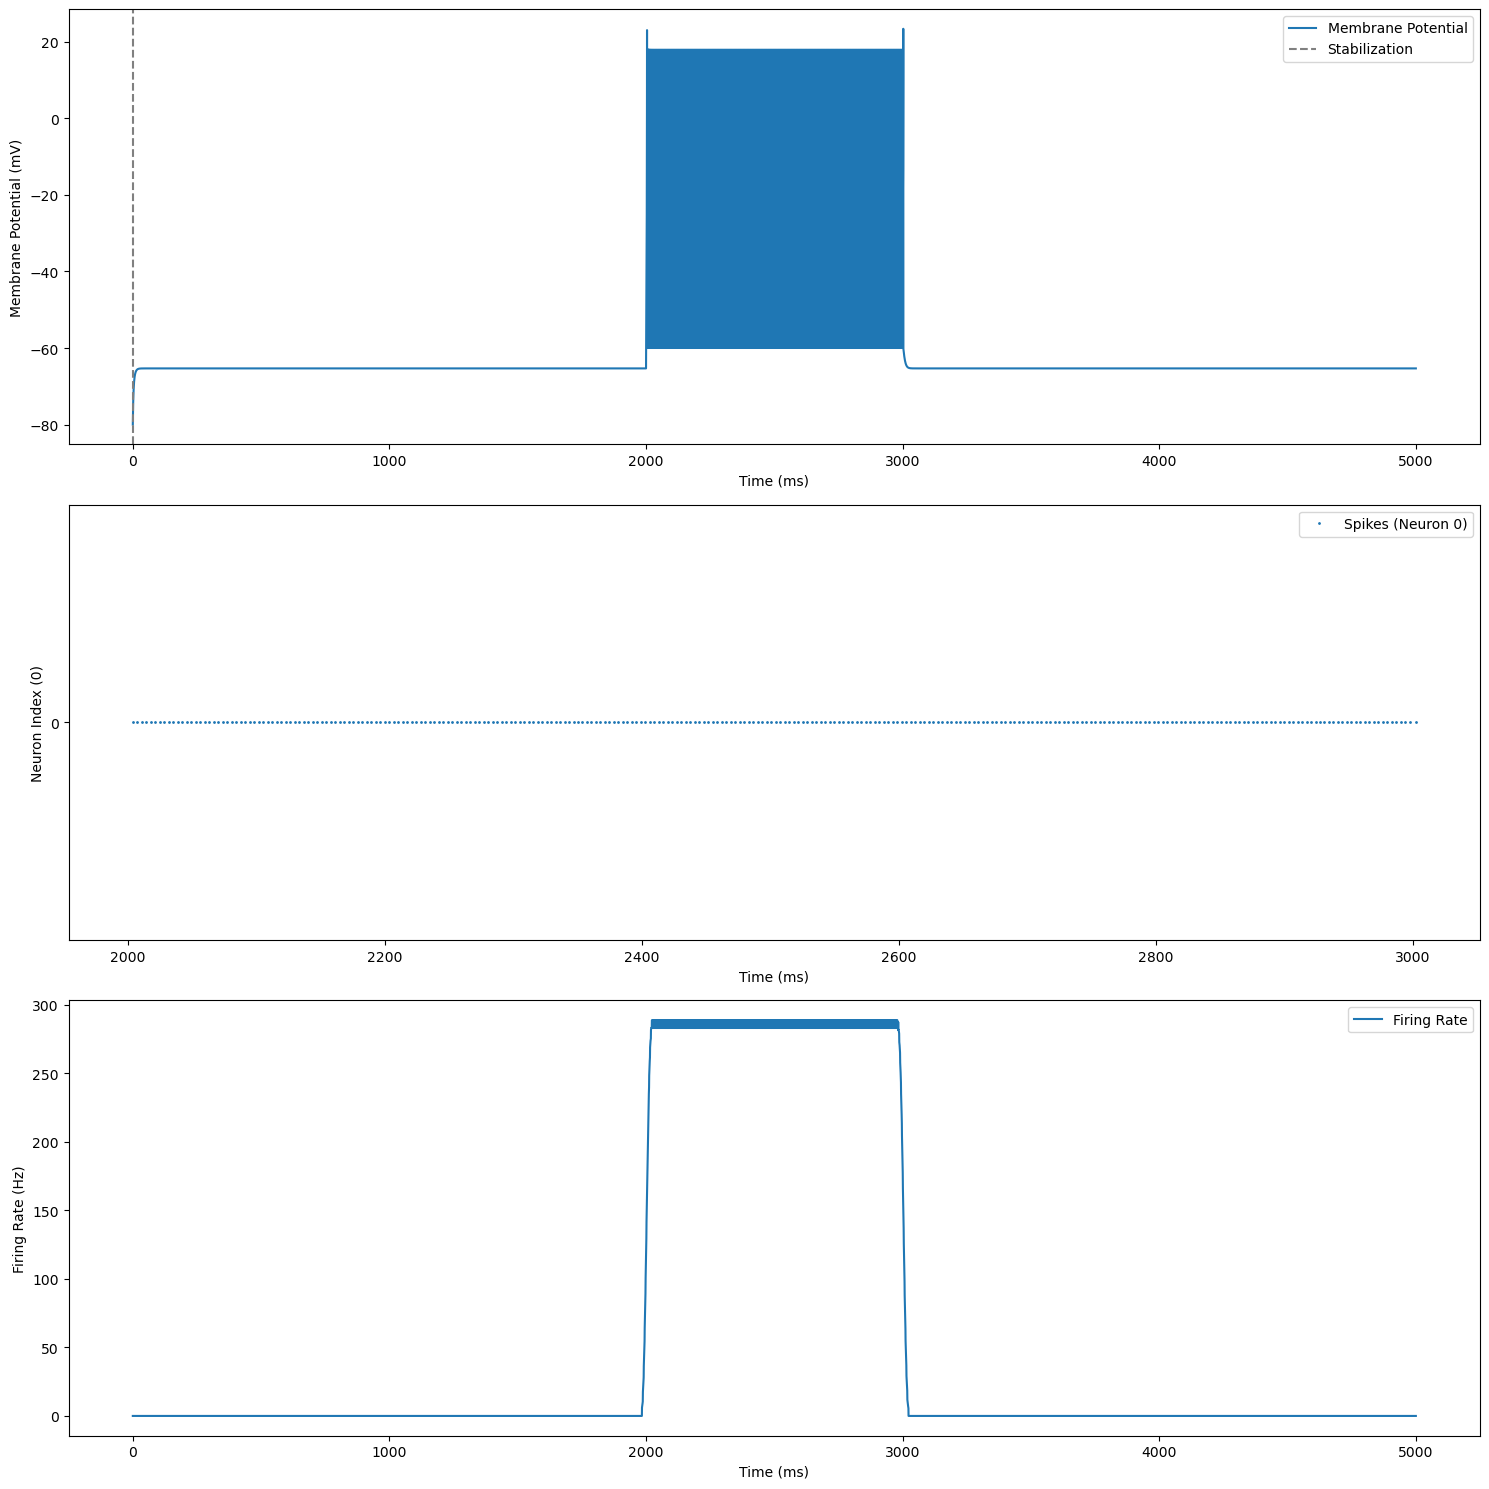

In [129]:
### Set 1 Final 

eqs = '''
dv/dt = (K*1*pF/ms/mV*(v-VR)*(v-vt)-u*pF+I)/C: volt
du/dt = a*(b*(v-VR)-u) : volt/second
VR = vr*(1+KAPA*Dop1) : volt
K = k*(1-ALPHA*Dop2) : 1
a       : 1/second
b       : 1/second
c       : volt
d       : volt/second
k       : 1
vr      : volt
vt      : volt
vpeak   : volt
I : amp
Dop1      : 1
Dop2      : 1
'''

dSPN = NeuronGroup(N, model = eqs,
                    threshold='v > vpeak',
                    reset='v = c; u += d',
                    method='euler')

dSPN.v = -80 * mV
dSPN.u = 0 * mV / ms
dSPN.a = 0.2 / ms
dSPN.b = 0.025 / ms
dSPN.c = -60 * mV
dSPN.d = 0 * mV / ms
dSPN.k = 1
dSPN.vr = -64.4 * mV 
dSPN.vt = -50 * mV
dSPN.vpeak = 25 * mV
dSPN.I = 0 * pA
dSPN.Dop1 = 0.5
dSPN.Dop2 = 0.5

Initialize_time = 1000 * ms 
time_after_increase = 1000 * ms 
time_after_decrease = 1000 * ms  

dv_monitor = StateMonitor(dSPN, variables='v', record=True)
spike_monitor = SpikeMonitor(dSPN)
rate_monitor = PopulationRateMonitor(dSPN) 

net = Network(dSPN, dv_monitor, spike_monitor, rate_monitor)
net.run(Initialize_time)

v_reset = -66 * mV 
membrane_potential = dv_monitor.v 
times = dv_monitor.t

matching_indices = np.where(membrane_potential / mV >= v_reset / mV)[0]

if len(matching_indices) > 0:
    earliest_time_stabilized = times[matching_indices[0]] * 1000 
else:
    earliest_time_stabilized = None

print("Earliest time when v stabilizes at v_reset (in ms):", earliest_time_stabilized)

dv_monitor_new = StateMonitor(dSPN, variables='v', record=True)
spike_monitor_new = SpikeMonitor(dSPN)
rate_monitor_new = PopulationRateMonitor(dSPN)

net.add(dv_monitor_new, spike_monitor_new, rate_monitor_new)

if earliest_time_stabilized is not None:
    wait_time_after_stabilization = 1000 * ms
    net.run(wait_time_after_stabilization)
    dSPN.I = 1 * nA
    net.run(time_after_increase)
    
    dSPN.I = 0 * pA
    net.run(time_after_decrease)

    net.run(simulation_time - earliest_time_stabilized - time_after_increase - time_after_decrease)
else:
    print("v do not reach v_reset, stop simulation")

plt.figure(figsize=(15, 15))

plt.subplot(3, 1, 1)
plt.plot(dv_monitor.t / ms, dv_monitor.v[0] / mV, label='Membrane Potential')
plt.axvline(x=earliest_time_stabilized / ms, color='gray', linestyle='--', label='Stabilization')
plt.xlabel('Time (ms)')
plt.ylabel('Membrane Potential (mV)')
plt.legend()

plt.subplot(3, 1, 2)
spikes_of_neuron_0 = spike_monitor.i[spike_monitor.i == 0]  
spike_times_of_neuron_0 = spike_monitor.t[spike_monitor.i == 0] 
plt.plot(spike_times_of_neuron_0 / ms, spikes_of_neuron_0, '.', markersize=2, label='Spikes (Neuron 0)')
plt.xlabel('Time (ms)')
plt.ylabel('Neuron Index (0)')
plt.yticks([0]) 
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(rate_monitor.t / ms, rate_monitor.smooth_rate(width=10*ms) / Hz, label='Firing Rate')
plt.xlabel('Time (ms)')
plt.ylabel('Firing Rate (Hz)')
plt.legend()

plt.tight_layout()
plt.show()

Earliest time when v stabilizes at v_reset (in ms): 0. s


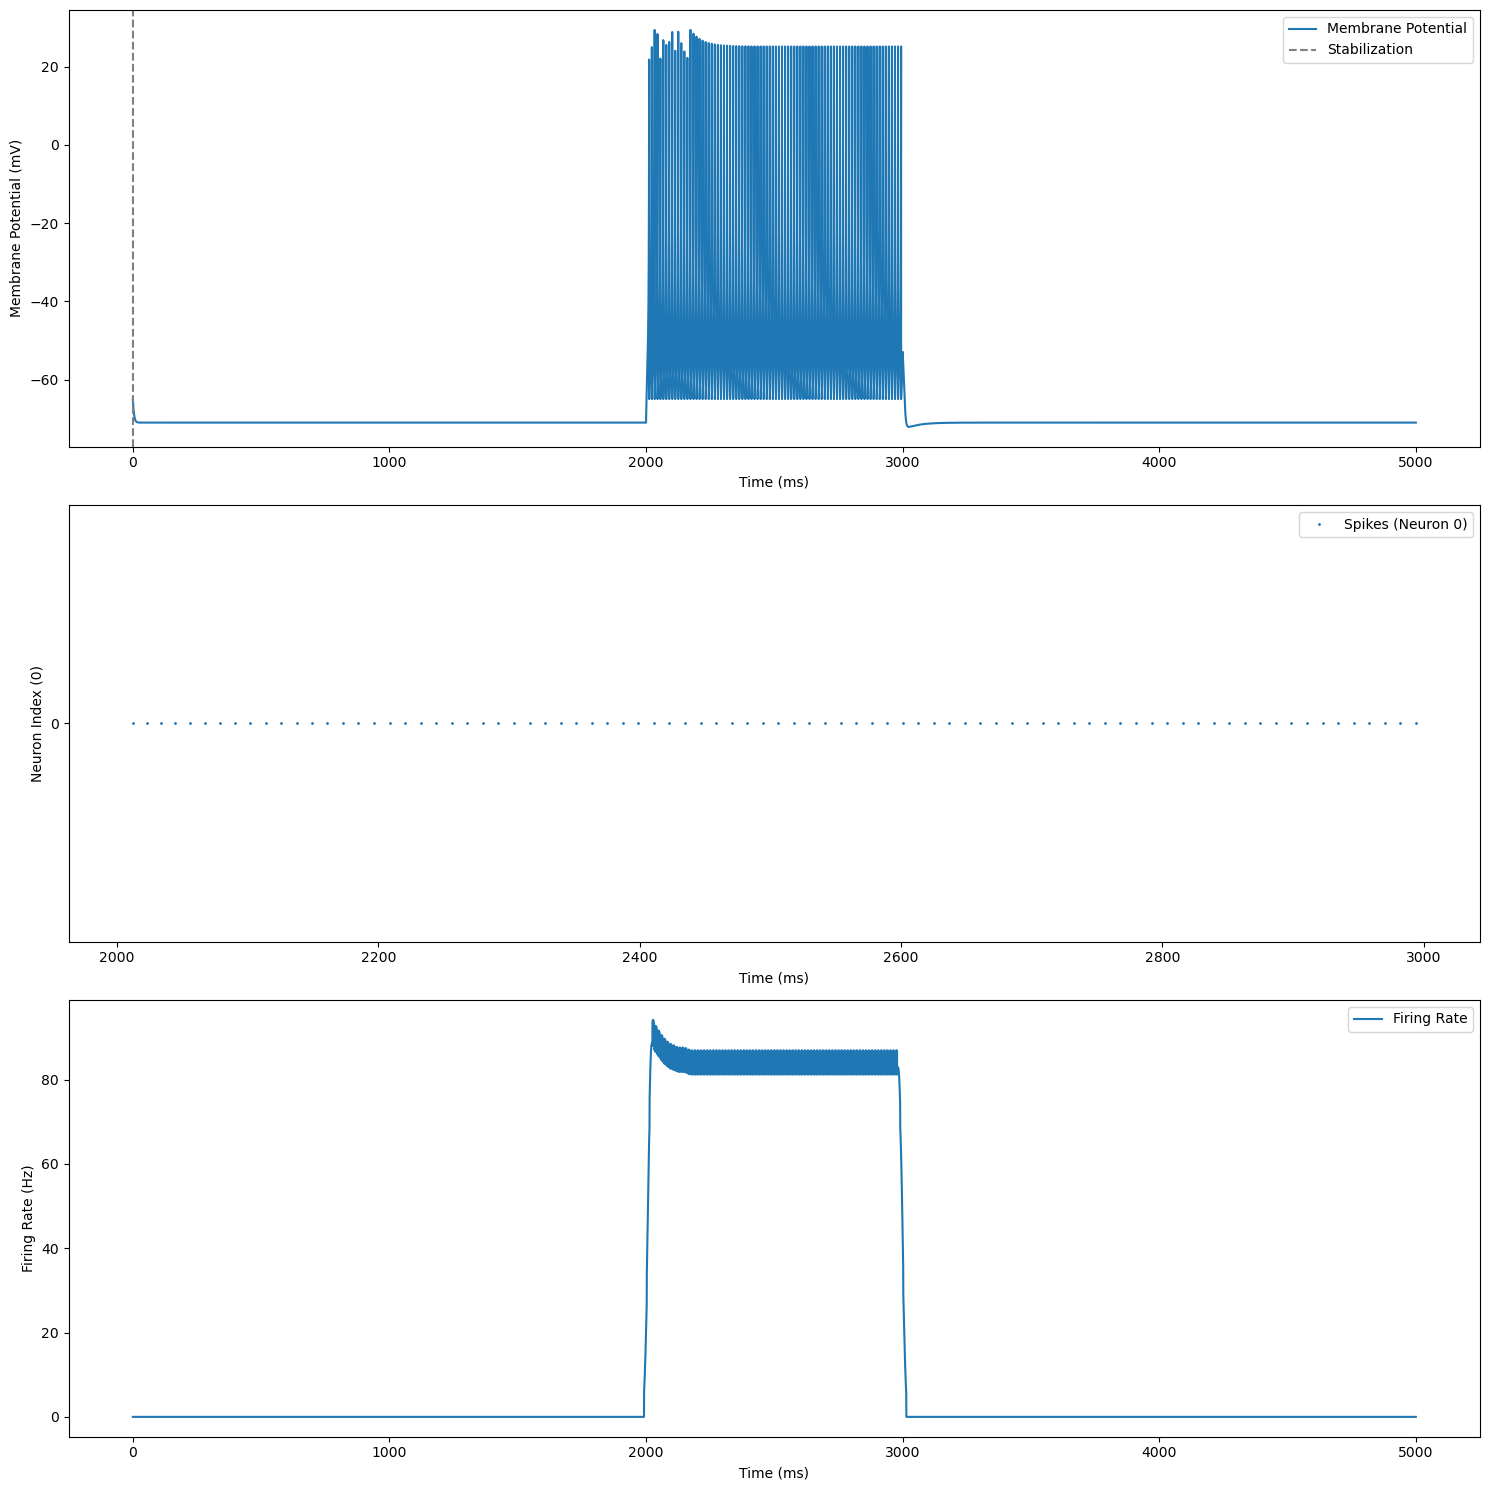

In [133]:
### Set 2

eqs = '''
dv/dt = (K*1*pF/ms/mV*(v-VR)*(v-vt)-u*pF+I)/C: volt
du/dt = a*(b*(v-VR)-u) : volt/second
VR = vr*(1+KAPA*Dop1) : volt
K = k*(1-ALPHA*Dop2) : 1
a       : 1/second
b       : 1/second
c       : volt
d       : volt/second
k       : 1
vr      : volt
vt      : volt
vpeak   : volt
I : amp
Dop1      : 1
Dop2      : 1
'''

dSPN = NeuronGroup(N, model = eqs,
                    threshold='v > vpeak',
                    reset='v = c; u += d',
                    method='euler')

dSPN.v = -65 * mV
dSPN.u = 0 * mV / ms
dSPN.a = 0.02 / ms
dSPN.b = 0.2 / ms
dSPN.c = -65 * mV
dSPN.d = 8 * mV / ms
dSPN.k = 1
dSPN.vr = -70 * mV 
dSPN.vt = -50 * mV
dSPN.vpeak = 30 * mV
dSPN.I = 0 * pA
dSPN.Dop1 = 0.5
dSPN.Dop2 = 0.5

# Set parameters
Initialize_time = 1000 * ms 
time_after_increase = 1000 * ms 
time_after_decrease = 1000 * ms 

dv_monitor = StateMonitor(dSPN, variables='v', record=True)
spike_monitor = SpikeMonitor(dSPN)
rate_monitor = PopulationRateMonitor(dSPN)  # 10ms의 bin 크기

net = Network(dSPN, dv_monitor, spike_monitor, rate_monitor)
net.run(Initialize_time)

# 막전위가 v_reset에 도달하여 안정화되는 시점 찾기
v_reset = -70 * mV 
membrane_potential = dv_monitor.v  # 막전위 모니터링 값
times = dv_monitor.t  # 시간 값

matching_indices = np.where(membrane_potential / mV >= v_reset / mV)[0]

if len(matching_indices) > 0:
    earliest_time_stabilized = times[matching_indices[0]] * 1000 
else:
    earliest_time_stabilized = None

print("Earliest time when v stabilizes at v_reset (in ms):", earliest_time_stabilized)

dv_monitor_new = StateMonitor(dSPN, variables='v', record=True)
spike_monitor_new = SpikeMonitor(dSPN)
rate_monitor_new = PopulationRateMonitor(dSPN)  # 10ms의 bin 크기

net.add(dv_monitor_new, spike_monitor_new, rate_monitor_new)

if earliest_time_stabilized is not None:
    # Increase I 
    wait_time_after_stabilization = 1000 * ms
    net.run(wait_time_after_stabilization)
    dSPN.I = 300 * pA
    net.run(time_after_increase)
    
    # decrease I 
    dSPN.I = 0 * pA
    net.run(time_after_decrease)

    net.run(simulation_time - earliest_time_stabilized - time_after_increase - time_after_decrease)
else:
    print("v do not reach v_reset, stop simulation")

### Visualization 
plt.figure(figsize=(15, 15))

plt.subplot(3, 1, 1)
plt.plot(dv_monitor.t / ms, dv_monitor.v[0] / mV, label='Membrane Potential')
plt.axvline(x=earliest_time_stabilized / ms, color='gray', linestyle='--', label='Stabilization')
plt.xlabel('Time (ms)')
plt.ylabel('Membrane Potential (mV)')
plt.legend()

plt.subplot(3, 1, 2)
spikes_of_neuron_0 = spike_monitor.i[spike_monitor.i == 0]  
spike_times_of_neuron_0 = spike_monitor.t[spike_monitor.i == 0]
plt.plot(spike_times_of_neuron_0 / ms, spikes_of_neuron_0, '.', markersize=2, label='Spikes (Neuron 0)')
plt.xlabel('Time (ms)')
plt.ylabel('Neuron Index (0)')
plt.yticks([0])
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(rate_monitor.t / ms, rate_monitor.smooth_rate(width=10*ms) / Hz, label='Firing Rate')
plt.xlabel('Time (ms)')
plt.ylabel('Firing Rate (Hz)')
plt.legend()

plt.tight_layout()
plt.show()

Earliest time when v stabilizes at v_reset (in ms): 0. s


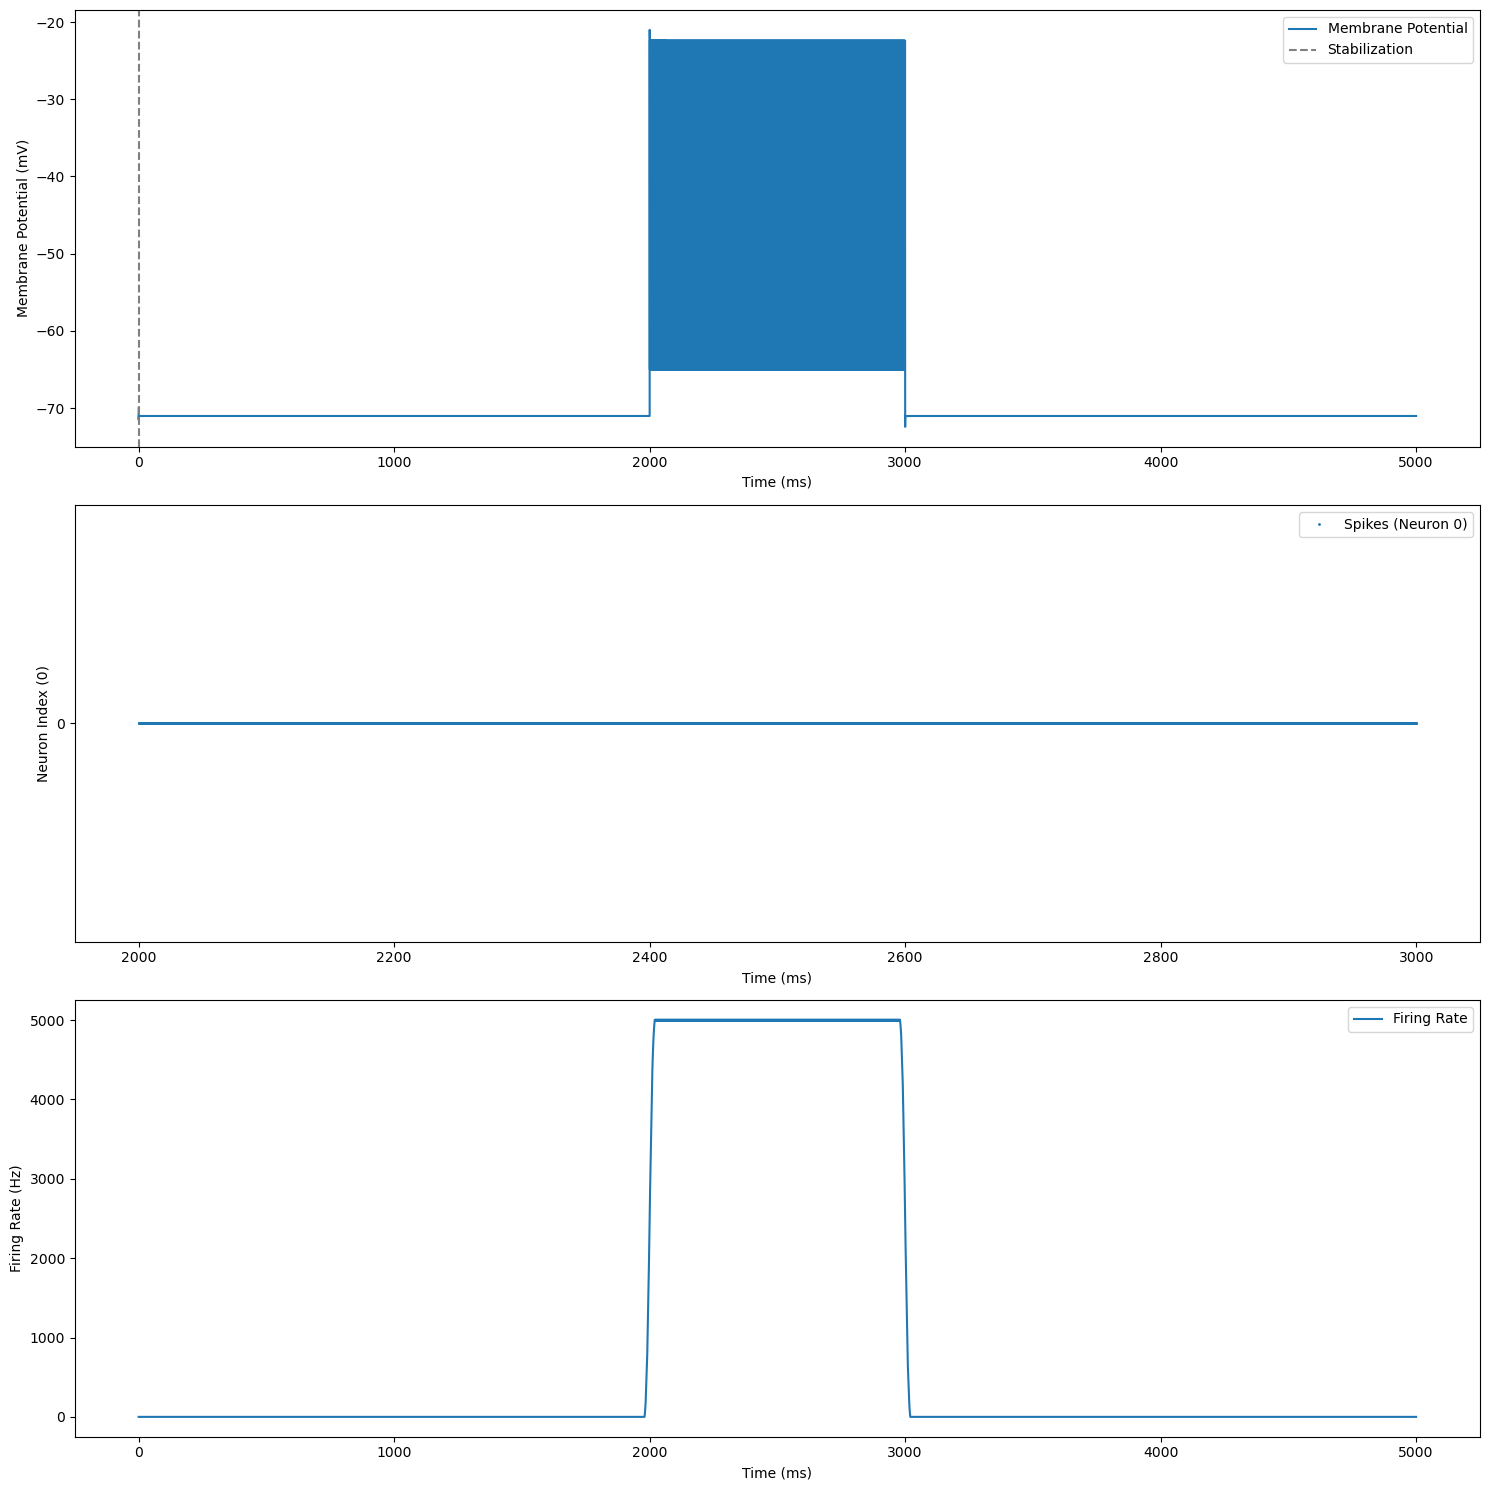

In [146]:
### Set 3: The onset of motor learning impairments in Parkinson’s disease: a computational investigation

eqs = '''
dv/dt = (K*1*pF/ms/mV*(v-VR)*(v-vt)-u*pF+I)/C: volt
du/dt = a*(b*(v-VR)-u) : volt/second
VR = vr*(1+KAPA*Dop1) : volt
K = k*(1-ALPHA*Dop2) : 1
a       : 1/second
b       : 1/second
c       : volt
d       : volt/second
k       : 1
vr      : volt
vt      : volt
vpeak   : volt
I : amp
Dop1      : 1
Dop2      : 1
'''

dSPN = NeuronGroup(N, model = eqs,
                    threshold='v > vpeak',
                    reset='v = c; u += d',
                    method='euler')

C = 2 * pF
dSPN.v = -70 * mV
dSPN.u = 0 * mV / ms
dSPN.a = 0.1 / ms
dSPN.b = 0.02 / ms
dSPN.c = -65 * mV
dSPN.d = 0 * mV / ms
dSPN.k = 1
dSPN.vr = -70 * mV 
dSPN.vt = -40 * mV
dSPN.vpeak = 25 * mV
dSPN.I = 0 * pA
dSPN.Dop1 = 0.5
dSPN.Dop2 = 0.5

# Set parameters
Initialize_time = 1000 * ms 
time_after_increase = 1000 * ms 
time_after_decrease = 1000 * ms  

dv_monitor = StateMonitor(dSPN, variables='v', record=True)
spike_monitor = SpikeMonitor(dSPN)
rate_monitor = PopulationRateMonitor(dSPN)  

net = Network(dSPN, dv_monitor, spike_monitor, rate_monitor)
net.run(Initialize_time)

# 막전위가 v_reset에 도달하여 안정화되는 시점 찾기
v_reset = -70 * mV
membrane_potential = dv_monitor.v 
times = dv_monitor.t 

matching_indices = np.where(membrane_potential / mV >= v_reset / mV)[0]

if len(matching_indices) > 0:
    earliest_time_stabilized = times[matching_indices[0]] * 1000 
else:
    earliest_time_stabilized = None

print("Earliest time when v stabilizes at v_reset (in ms):", earliest_time_stabilized)

dv_monitor_new = StateMonitor(dSPN, variables='v', record=True)
spike_monitor_new = SpikeMonitor(dSPN)
rate_monitor_new = PopulationRateMonitor(dSPN)  

net.add(dv_monitor_new, spike_monitor_new, rate_monitor_new)

if earliest_time_stabilized is not None:
    # Increase I 
    wait_time_after_stabilization = 1000 * ms
    net.run(wait_time_after_stabilization)
    dSPN.I = 1000 * pA
    net.run(time_after_increase)
    
    # decrease I 
    dSPN.I = 0 * pA
    net.run(time_after_decrease)

    net.run(simulation_time - earliest_time_stabilized - time_after_increase - time_after_decrease)
else:
    print("v do not reach v_reset, stop simulation")

### Visualization 
plt.figure(figsize=(15, 15))

plt.subplot(3, 1, 1)
plt.plot(dv_monitor.t / ms, dv_monitor.v[0] / mV, label='Membrane Potential')
plt.axvline(x=earliest_time_stabilized / ms, color='gray', linestyle='--', label='Stabilization')
plt.xlabel('Time (ms)')
plt.ylabel('Membrane Potential (mV)')
plt.legend()

plt.subplot(3, 1, 2)
spikes_of_neuron_0 = spike_monitor.i[spike_monitor.i == 0] 
spike_times_of_neuron_0 = spike_monitor.t[spike_monitor.i == 0] 
plt.plot(spike_times_of_neuron_0 / ms, spikes_of_neuron_0, '.', markersize=2, label='Spikes (Neuron 0)')
plt.xlabel('Time (ms)')
plt.ylabel('Neuron Index (0)')
plt.yticks([0]) 
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(rate_monitor.t / ms, rate_monitor.smooth_rate(width=10*ms) / Hz, label='Firing Rate')
plt.xlabel('Time (ms)')
plt.ylabel('Firing Rate (Hz)')
plt.legend()

plt.tight_layout()
plt.show()